In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from tslearn.svm import TimeSeriesSVR

In [2]:
TRAIN_TEST_SPLIT = 0.8

In [3]:
labels = ['PM2.5_pi', 'PM10_pi']

In [72]:
data1 = pd.read_csv('30min_1.csv')[labels[0]]
data2 = pd.read_csv('1h_1.csv')[labels[0]]

In [76]:
data1 = data1[0:200]
data2 = data2[0:100]

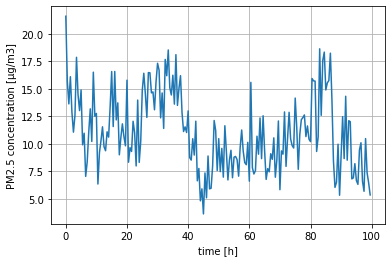

In [84]:
plt.plot(np.arange(len(data1))/2, data1)
plt.grid()
plt.xlabel('time [h]')
plt.ylabel('PM2.5 concentration [µg/m3]')
plt.savefig('30min_extract.png', dpi=150)
plt.show()

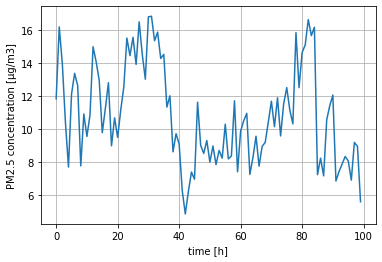

In [85]:
plt.plot(np.arange(len(data2)), data2)
plt.grid()
plt.xlabel('time [h]')
plt.ylabel('PM2.5 concentration [µg/m3]')
plt.savefig('1h_extract.png', dpi=150)
plt.show()

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


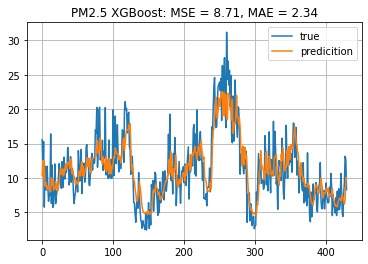

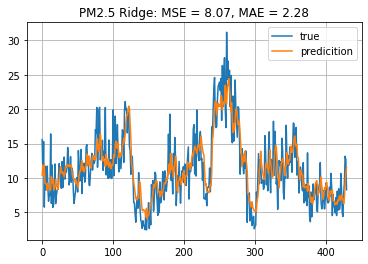

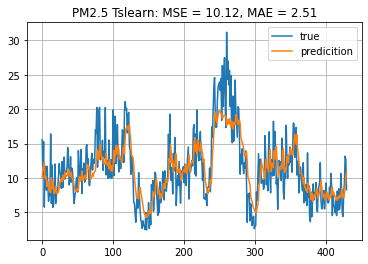

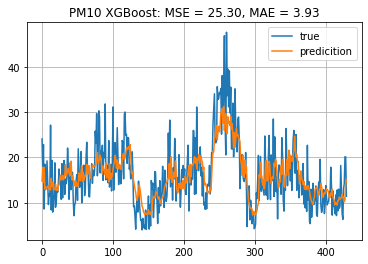

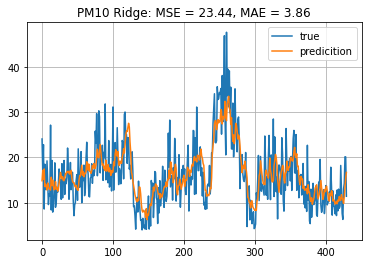

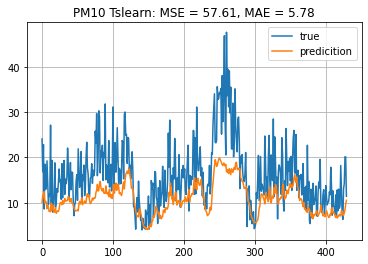

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


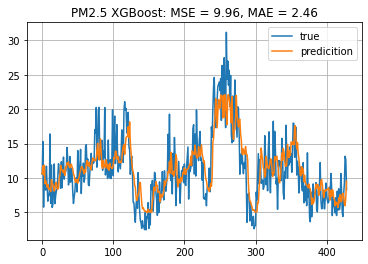

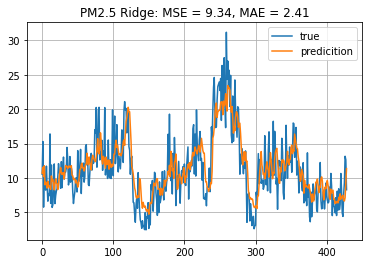

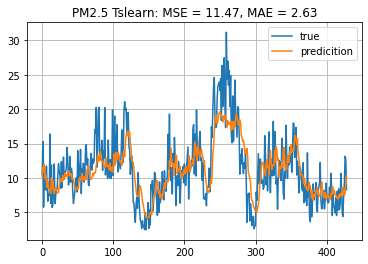

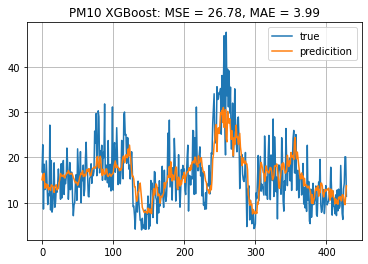

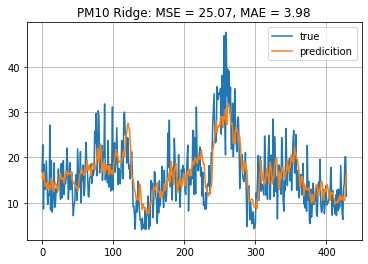

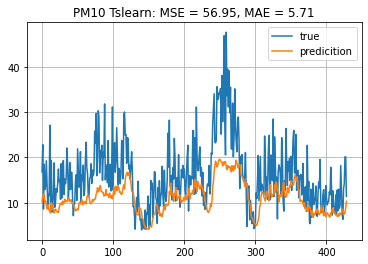

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


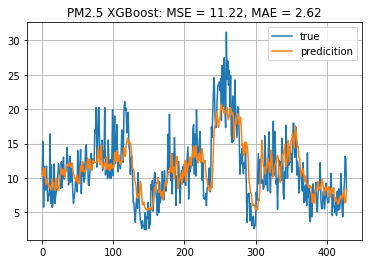

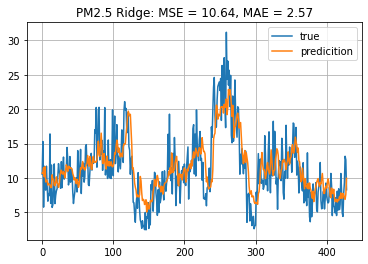

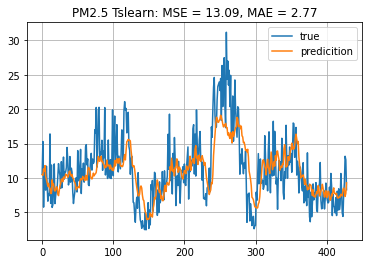

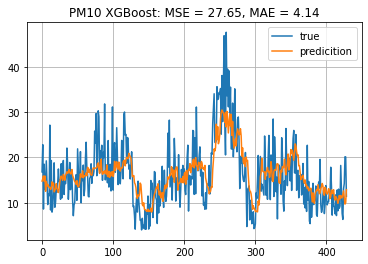

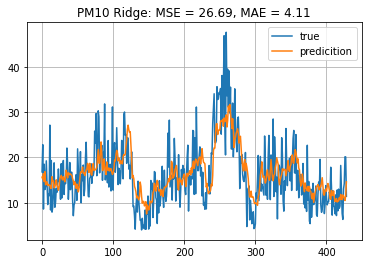

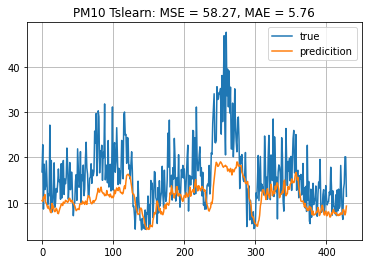

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


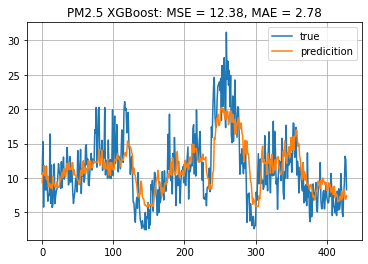

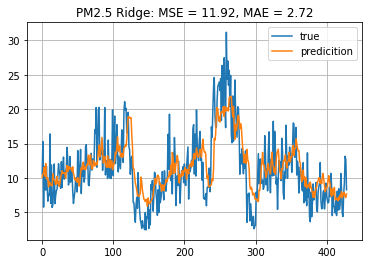

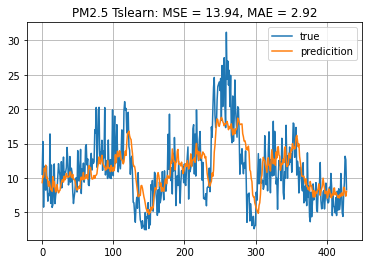

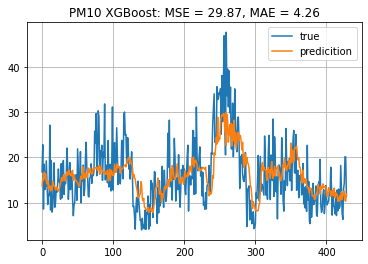

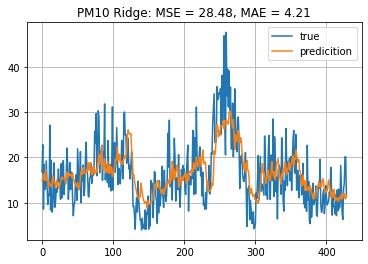

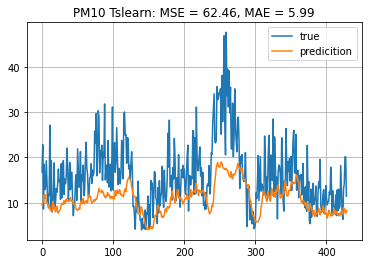

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


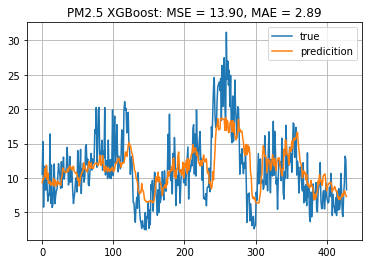

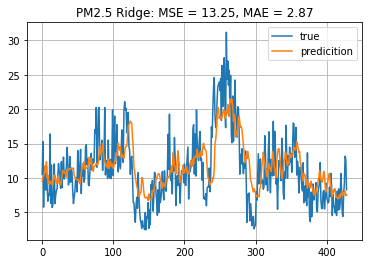

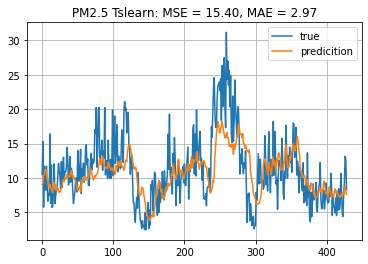

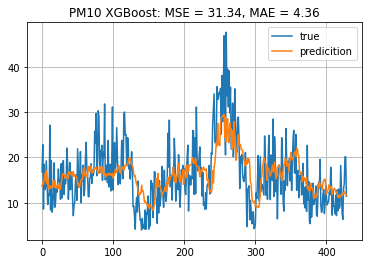

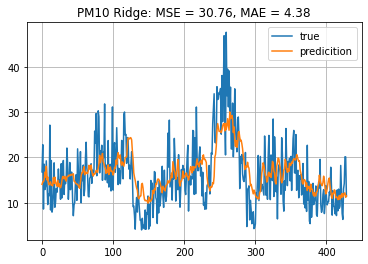

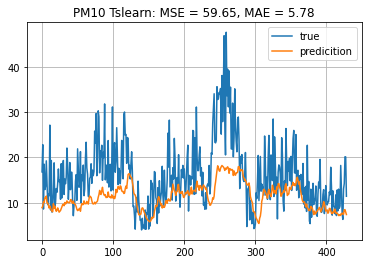

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


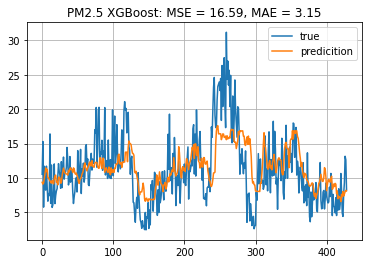

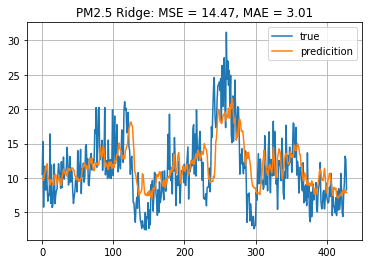

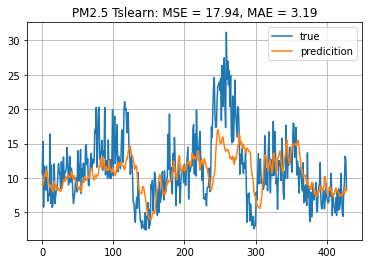

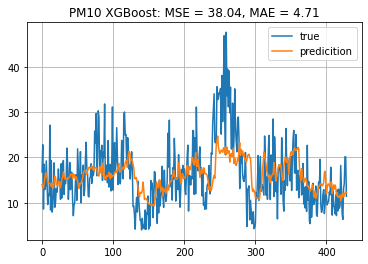

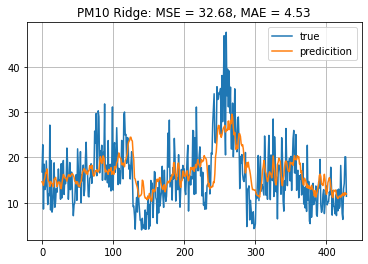

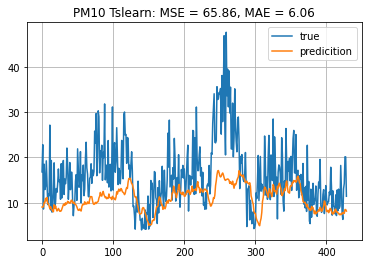

In [6]:
results_30m = []
for i in range(1, 7):
    #Fetch and prepare data
    s = '30min_' + str(i) + '.csv'
    data = pd.read_csv(s)
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    data = data.iloc[:2147-i,:]
    
    #Split data
    n = int(TRAIN_TEST_SPLIT*data.shape[0])

    X_train = data.iloc[:n,:]
    X_test = data.iloc[n:,:]

    y_train25 = X_train[labels[0]]
    y_train10 = X_train[labels[1]]

    y_true25 = X_test[labels[0]]
    y_true10 = X_test[labels[1]]

    X_train = X_train.drop(labels, axis=1)
    X_test = X_test.drop(labels, axis=1)
    
    #Define models
    xgb25 = XGBRegressor(colsample_bytree=0.5, learning_rate= 0.01, max_depth=2, n_estimators=500)
    xgb10 = XGBRegressor(colsample_bytree=0.5, learning_rate= 0.01, max_depth=3, n_estimators=500)
    
    ridge25 = Ridge(alpha=110)
    ridge10 = Ridge(alpha=150)
    
    ts25 = TimeSeriesSVR(C=1.0, kernel="gak", n_jobs=-1)
    ts10 = TimeSeriesSVR(C=1.0, kernel="gak", n_jobs=-1)
    
    #Train models
    xgb25.fit(X_train.values, y_train25)
    xgb10.fit(X_train.values, y_train10)
    
    ridge25.fit(X_train.values, y_train25)
    ridge10.fit(X_train.values, y_train10)

    ts25.fit(np.array(X_train), y_train25)
    ts10.fit(np.array(X_train), y_train25)
    
    #Perform predictions
    xgb_pred25 = xgb25.predict(X_test)
    xgb_pred10 = xgb10.predict(X_test)
    
    ridge_pred25 = ridge25.predict(X_test)
    ridge_pred10 = ridge10.predict(X_test)
    
    ts_pred25 = ts25.predict(np.array(X_test))
    ts_pred10 = ts10.predict(np.array(X_test))
    
    #Results
    xgb_mse25 = mean_squared_error(y_true25, xgb_pred25)
    xgb_mae25 = mean_absolute_error(y_true25, xgb_pred25)
    
    xgb_mse10 = mean_squared_error(y_true10, xgb_pred10)
    xgb_mae10 = mean_absolute_error(y_true10, xgb_pred10)
    
    ridge_mse25 = mean_squared_error(y_true25, ridge_pred25)
    ridge_mae25 = mean_absolute_error(y_true25, ridge_pred25)
    
    ridge_mse10 = mean_squared_error(y_true10, ridge_pred10)
    ridge_mae10 = mean_absolute_error(y_true10, ridge_pred10)
    
    ts_mse25 = mean_squared_error(y_true25, ts_pred25)
    ts_mae25 = mean_absolute_error(y_true25, ts_pred25)
    
    ts_mse10 = mean_squared_error(y_true10, ts_pred10)
    ts_mae10 = mean_absolute_error(y_true10, ts_pred10)
    
    results_30m.append([xgb_mse25, xgb_mae25, xgb_mse10, xgb_mae10, ridge_mse25, ridge_mae25, ridge_mse10, ridge_mae10, ts_mse25, ts_mae25, ts_mse10, ts_mae10])
    
    #Plot
    plt.plot(np.arange(len(y_true25)), y_true25, label='true')
    plt.plot(np.arange(len(xgb_pred25)), xgb_pred25, label='predicition')
    plt.title(f'PM2.5 XGBoost: MSE = {format(xgb_mse25,".2f")}, MAE = {format(xgb_mae25,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true25)), y_true25, label='true')
    plt.plot(np.arange(len(ridge_pred25)), ridge_pred25, label='predicition')
    plt.title(f'PM2.5 Ridge: MSE = {format(ridge_mse25,".2f")}, MAE = {format(ridge_mae25,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true25)), y_true25, label='true')
    plt.plot(np.arange(len(ts_pred25)), ts_pred25, label='predicition')
    plt.title(f'PM2.5 Tslearn: MSE = {format(ts_mse25,".2f")}, MAE = {format(ts_mae25,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(np.arange(len(y_true10)), y_true10, label='true')
    plt.plot(np.arange(len(xgb_pred10)), xgb_pred10, label='predicition')
    plt.title(f'PM10 XGBoost: MSE = {format(xgb_mse10,".2f")}, MAE = {format(xgb_mae10,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true10)), y_true10, label='true')
    plt.plot(np.arange(len(ridge_pred10)), ridge_pred10, label='predicition')
    plt.title(f'PM10 Ridge: MSE = {format(ridge_mse10,".2f")}, MAE = {format(ridge_mae10,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true10)), y_true10, label='true')
    plt.plot(np.arange(len(ts_pred10)), ts_pred10, label='predicition')
    plt.title(f'PM10 Tslearn: MSE = {format(ts_mse10,".2f")}, MAE = {format(ts_mae10,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    

In [7]:
header = ['XGB MSE 2.5', 'XGB MAE 2.5', 'XGB MSE 10', 'XGB MAE 10', 'Ridge MSE 2.5', 'Ridge MAE 2.5', 'Ridge MSE 10', 'Ridge MAE 10', 'Tslearn MSE 2.5', 'Tslearn MAE 2.5', 'Tslearn MSE 10', 'Tslearn MAE 10']
results_30m = pd.DataFrame(results_30m, columns=header)
results_30m.to_csv("results_30min_80.csv")

In [16]:
results_30m = pd.read_csv("results_30min_80.csv")
results_30m

,Unnamed: 0,XGB MSE 2.5,XGB MAE 2.5,XGB MSE 10,XGB MAE 10,Ridge MSE 2.5,Ridge MAE 2.5,Ridge MSE 10,Ridge MAE 10,Tslearn MSE 2.5,Tslearn MAE 2.5,Tslearn MSE 10,Tslearn MAE 10
0,0,8.714621,2.344323,25.298088,3.932553,8.069438,2.276089,23.441475,3.864221,10.121312,2.508534,57.606899,5.781722
1,1,9.961368,2.456437,26.778579,3.992034,9.337201,2.412557,25.068118,3.976446,11.468474,2.634027,56.950995,5.705196
2,2,11.218493,2.619891,27.654974,4.136066,10.637500,2.567290,26.689705,4.105435,13.092732,2.774385,58.273468,5.758257
3,3,12.379633,2.781315,29.872711,4.263058,11.915574,2.722851,28.480934,4.205552,13.937975,2.918210,62.463803,5.989161
4,4,13.897815,2.894713,31.342452,4.358529,13.252800,2.866670,30.756276,4.375272,15.396277,2.965254,59.650654,5.776440
5,5,16.585818,3.150222,38.037705,4.705976,14.465923,3.010350,32.679931,4.526299,17.943865,3.189711,65.856223,6.056487


In [8]:
results_1h = []
for i in range(1, 7):
    #Fetch and prepare data
    s = '1h_' + str(i) + '.csv'
    data = pd.read_csv(s)
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    data = data.iloc[:1074-i,:]
    
    #Split data
    n = int(TRAIN_TEST_SPLIT*data.shape[0])

    X_train = data.iloc[:n,:]
    X_test = data.iloc[n:,:]

    y_train25 = X_train[labels[0]]
    y_train10 = X_train[labels[1]]

    y_true25 = X_test[labels[0]]
    y_true10 = X_test[labels[1]]

    X_train = X_train.drop(labels, axis=1)
    X_test = X_test.drop(labels, axis=1)
    
    #Define models
    xgb25 = XGBRegressor(colsample_bytree=0.5, learning_rate= 0.01, max_depth=2, n_estimators=500)
    xgb10 = XGBRegressor(colsample_bytree=0.5, learning_rate= 0.01, max_depth=3, n_estimators=500)
    
    ridge25 = Ridge(alpha=110)
    ridge10 = Ridge(alpha=150)
    
    ts25 = TimeSeriesSVR(C=1.0, kernel="gak", n_jobs=-1)
    ts10 = TimeSeriesSVR(C=1.0, kernel="gak", n_jobs=-1)
    
    #Train models
    xgb25.fit(X_train.values, y_train25)
    xgb10.fit(X_train.values, y_train10)
    
    ridge25.fit(X_train.values, y_train25)
    ridge10.fit(X_train.values, y_train10)
    
    ts25.fit(X_train.values, y_train25)
    ts10.fit(X_train.values, y_train25)
    
    #Perform predictions
    xgb_pred25 = xgb25.predict(X_test)
    xgb_pred10 = xgb10.predict(X_test)
    
    ridge_pred25 = ridge25.predict(X_test)
    ridge_pred10 = ridge10.predict(X_test)
    
    ts_pred25 = ts25.predict(X_test.values)
    ts_pred10 = ts10.predict(X_test.values)
    
    #Results
    xgb_mse25 = mean_squared_error(y_true25, xgb_pred25)
    xgb_mae25 = mean_absolute_error(y_true25, xgb_pred25)
    
    xgb_mse10 = mean_squared_error(y_true10, xgb_pred10)
    xgb_mae10 = mean_absolute_error(y_true10, xgb_pred10)
    
    ridge_mse25 = mean_squared_error(y_true25, ridge_pred25)
    ridge_mae25 = mean_absolute_error(y_true25, ridge_pred25)
    
    ridge_mse10 = mean_squared_error(y_true10, ridge_pred10)
    ridge_mae10 = mean_absolute_error(y_true10, ridge_pred10)
    
    ts_mse25 = mean_squared_error(y_true25, ts_pred25)
    ts_mae25 = mean_absolute_error(y_true25, ts_pred25)
    
    ts_mse10 = mean_squared_error(y_true10, ts_pred10)
    ts_mae10 = mean_absolute_error(y_true10, ts_pred10)
    
    results_1h.append([xgb_mse25, xgb_mae25, xgb_mse10, xgb_mae10, ridge_mse25, ridge_mae25, ridge_mse10, ridge_mae10, ts_mse25, ts_mae25, ts_mse10, ts_mae10])
    
    #Plot
    plt.plot(np.arange(len(y_true25)), y_true25, label='true')
    plt.plot(np.arange(len(xgb_pred25)), xgb_pred25, label='predicition')
    plt.title(f'PM2.5 XGBoost: MSE = {format(xgb_mse25,".2f")}, MAE = {format(xgb_mae25,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true25)), y_true25, label='true')
    plt.plot(np.arange(len(ridge_pred25)), ridge_pred25, label='predicition')
    plt.title(f'PM2.5 Ridge: MSE = {format(ridge_mse25,".2f")}, MAE = {format(ridge_mae25,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true25)), y_true25, label='true')
    plt.plot(np.arange(len(ts_pred25)), ts_pred25, label='predicition')
    plt.title(f'PM2.5 Tslearn: MSE = {format(ts_mse25,".2f")}, MAE = {format(ts_mae25,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true10)), y_true10, label='true')
    plt.plot(np.arange(len(xgb_pred10)), xgb_pred10, label='predicition')
    plt.title(f'PM10 XGBoost: MSE = {format(xgb_mse10,".2f")}, MAE = {format(xgb_mae10,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true10)), y_true10, label='true')
    plt.plot(np.arange(len(ridge_pred10)), ridge_pred10, label='predicition')
    plt.title(f'PM10 Ridge: MSE = {format(ridge_mse10,".2f")}, MAE = {format(ridge_mae10,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true10)), y_true10, label='true')
    plt.plot(np.arange(len(ts_pred10)), ts_pred10, label='predicition')
    plt.title(f'PM10 Tslearn: MSE = {format(ts_mse10,".2f")}, MAE = {format(ts_mae10,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()

SyntaxError: invalid syntax (<ipython-input-8-1ed27625bac2>, line 75)

In [ ]:
header = ['XGB MSE 2.5', 'XGB MAE 2.5', 'XGB MSE 10', 'XGB MAE 10', 'Ridge MSE 2.5', 'Ridge MAE 2.5', 'Ridge MSE 10', 'Ridge MAE 10', 'Tslearn MSE 2.5', 'Tslearn MAE 2.5', 'Tslearn MSE 10', 'Tslearn MAE 10']
results_1h = pd.DataFrame(results_1h, columns=header)
results_1h.to_csv("results_1h_80.csv")

In [15]:
results_1h = pd.read_csv("results_1h_80.csv")
results_1h

,Unnamed: 0,XGB MSE 2.5,XGB MAE 2.5,XGB MSE 10,XGB MAE 10,Ridge MSE 2.5,Ridge MAE 2.5,Ridge MSE 10,Ridge MAE 10,Tslearn MSE 2.5,Tslearn MAE 2.5,Tslearn MSE 10,Tslearn MAE 10
0,0,5.910274,1.940337,15.530129,3.170883,5.385624,1.846933,13.330798,2.997749,8.567777,2.326217,43.995654,5.230951
1,1,8.957408,2.302048,22.334253,3.528057,8.163322,2.222720,17.120918,3.282179,10.959972,2.598293,50.820061,5.541296
2,2,12.413529,2.723033,27.659355,4.017406,10.465728,2.521488,20.676806,3.607831,13.168508,2.791997,54.528541,5.715060
3,3,14.548227,2.910534,30.286632,4.157071,12.551683,2.693205,24.320055,3.806168,14.968464,2.964026,63.044161,6.149490
4,4,15.182610,2.964466,31.169711,4.260476,14.691571,2.933433,28.378314,4.073774,17.518965,3.152152,69.409869,6.408488
5,5,16.923250,3.104194,34.159938,4.452547,16.654226,3.137978,32.213129,4.322157,21.294317,3.419831,75.590464,6.703258


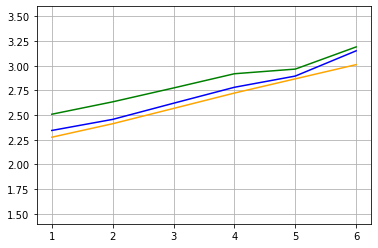

In [172]:
plt.plot(5.5, 1.5, color='white')
plt.plot(5.5, 3.5, color='white')
plt.plot(np.arange(1,7), results_30m['XGB MAE 2.5'], label='xgb', color='blue')
plt.plot(np.arange(1,7), results_30m['Ridge MAE 2.5'], label='ridge', color='orange')
plt.plot(np.arange(1,7), results_30m['Tslearn MAE 2.5'], label='tslearn', color='green')
plt.grid()
plt.savefig('30min.png', dpi=150)
plt.show()

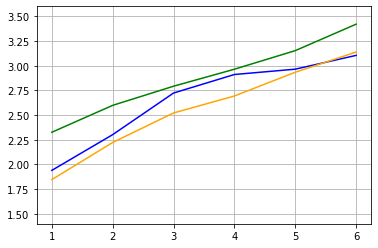

In [173]:
plt.plot(5.5, 1.5, color='white')
plt.plot(5.5, 3.5, color='white')
plt.plot(np.arange(1,7), results_1h['XGB MAE 2.5'], label='xgb', color='blue')
plt.plot(np.arange(1,7), results_1h['Ridge MAE 2.5'], label='ridge', color='orange')
plt.plot(np.arange(1,7), results_1h['Tslearn MAE 2.5'], label='tslearn', color='green')
plt.grid()
plt.savefig('1h.png', dpi=150)
plt.show()

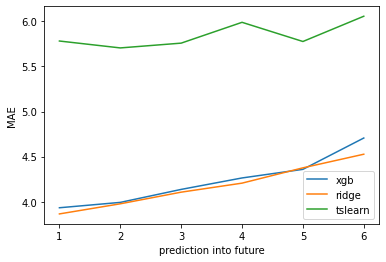

In [19]:
plt.plot(np.arange(1,7), results_30m['XGB MAE 10'], label='xgb')
plt.plot(np.arange(1,7), results_30m['Ridge MAE 10'], label='ridge')
plt.plot(np.arange(1,7), results_30m['Tslearn MAE 10'], label='tslearn')
plt.xlabel("prediction into future")
plt.ylabel("MAE")
plt.legend()
plt.show()

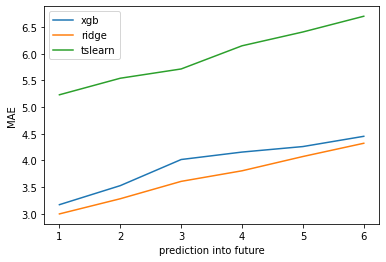

In [20]:
plt.plot(np.arange(1,7), results_1h['XGB MAE 10'], label='xgb')
plt.plot(np.arange(1,7), results_1h['Ridge MAE 10'], label='ridge')
plt.plot(np.arange(1,7), results_1h['Tslearn MAE 10'], label='tslearn')
plt.xlabel("prediction into future")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [159]:
data = pd.read_csv('1h_1.csv')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data = data.iloc[:1074-i,:]

n = int(TRAIN_TEST_SPLIT*data.shape[0])

X_train = data.iloc[:n,:]
X_test = data.iloc[n:,:]

y_train25 = X_train[labels[0]]
y_train10 = X_train[labels[1]]

y_true25 = X_test[labels[0]]
y_true10 = X_test[labels[1]]

X_train = X_train.drop(labels, axis=1)
X_test = X_test.drop(labels, axis=1)

X_vis = X_test.iloc[20:40,:]
y_vis25 = y_true25[20:40]
y_vis10 = y_true10[20:40]

In [22]:
xgb25 = XGBRegressor(colsample_bytree=0.5, learning_rate= 0.01, max_depth=2, n_estimators=500)
xgb10 = XGBRegressor(colsample_bytree=0.5, learning_rate= 0.01, max_depth=3, n_estimators=500)
    
ridge25 = Ridge(alpha=110)
ridge10 = Ridge(alpha=150)
    
ts25 = TimeSeriesSVR(C=1.0, kernel="gak", n_jobs=-1)
ts10 = TimeSeriesSVR(C=1.0, kernel="gak", n_jobs=-1)

In [118]:
xgb25.fit(X_train.values, y_train25)
xgb10.fit(X_train.values, y_train10)
    
ridge25.fit(X_train.values, y_train25)
ridge10.fit(X_train.values, y_train10)
    
ts25.fit(X_train.values, y_train25)
ts10.fit(X_train.values, y_train25)

TimeSeriesSVR(n_jobs=-1)

In [119]:
X_vis = X_test.iloc[27:35,:]
y_vis25 = y_true25[27:35]
y_vis10 = y_true10[27:35]

In [120]:
xgb_pred25 = xgb25.predict(X_vis.values)
xgb_pred10 = xgb10.predict(X_vis.values)
    
ridge_pred25 = ridge25.predict(X_vis.values)
ridge_pred10 = ridge10.predict(X_vis.values)
    
ts_pred25 = ts25.predict(X_vis.values)
ts_pred10 = ts10.predict(X_vis.values)

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


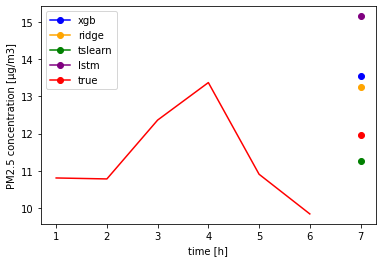

In [136]:
l = len(y_vis25) - 2
#plt.plot(np.arange(1,l), xgb_pred25, label='xgb')
plt.plot(l+1, xgb_pred25[l+1], label='xgb', marker='o', color='blue')
#plt.plot(np.arange(1,l), ridge_pred25, label='ridge')
plt.plot(l+1, ridge_pred25[l+1], label='ridge', marker='o', color='orange')
#plt.plot(np.arange(1,l), ts_pred25, label='tslearn')
plt.plot(l+1, ts_pred25[l+1], label='tslearn', marker='o', color='green')

plt.plot(l+1, lstm_pred25.iloc[l+1], label='lstm', marker='o', color='purple')

plt.plot(np.arange(1,l+1), y_vis25[:l], color='red')
plt.plot(l+1, y_vis25.iloc[l+1], label='true', color='red', marker='o')
plt.legend()
plt.xlabel('time [h]')
plt.ylabel('PM2.5 concentration [µg/m3]')
plt.savefig('test.png', dpi=150)
plt.show()

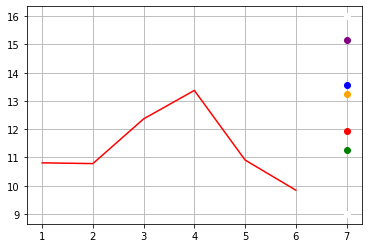

In [134]:
l = len(y_vis25) - 2
#plt.plot(np.arange(1,l), xgb_pred25, label='xgb')
plt.plot(l+1, 16, marker='o', color='white')
plt.plot(l+1, 9, marker='o', color='white')
plt.plot(l+1, xgb_pred25[l+1], marker='o', color='blue')
plt.plot(l+1, ridge_pred25[l+1], label='ridge', marker='o', color='orange')
#plt.plot(np.arange(1,l), ts_pred25, label='tslearn')
plt.plot(l+1, ts_pred25[l+1], label='tslearn', marker='o', color='green')

plt.plot(l+1, lstm_pred25.iloc[l+1], label='lstm', marker='o', color='purple')

plt.plot(np.arange(1,l+1), y_vis25[:l], color='red')
plt.plot(l+1, y_vis25.iloc[l+1], label='true', color='red', marker='o')
#plt.margins(x=0.5)
plt.grid()
plt.savefig('6.png', dpi=150)
plt.show()

In [58]:
y_vis25.iloc[7]

12.365

In [174]:
results25 = pd.read_csv('../results25_1.csv')

In [175]:
y_true = results25['y_true']

In [176]:
lstm_25 = results25['y_pred']

In [112]:
lstm_pred25 = lstm_25[26:34]

In [113]:
lstm_pred25

26    15.664202
27    15.527091
28    15.665520
29    15.465531
30    16.937925
31    16.563002
32    16.123737
33    15.157372
Name: y_pred, dtype: float64

In [110]:
y_true[26:34]

26    10.808333
27    10.782500
28    12.365000
29    13.373333
30    10.908333
31     9.841667
32    13.030833
33    11.953333
Name: y_true, dtype: float64

In [111]:
y_true25[27:35]

886    10.808333
887    10.782500
888    12.365000
889    13.373333
890    10.908333
891     9.841667
892    13.030833
893    11.953333
Name: PM2.5_pi, dtype: float64

In [177]:
xgb_pred25 = xgb25.predict(X_test.values)
ridge_pred25 = ridge25.predict(X_test.values)
ts_pred25 = ts25.predict(X_test.values)

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [179]:
xgb_pred25 = xgb_pred25[20:100]
ridge_pred25 = ridge_pred25[20:100]
ts_pred25 = ts_pred25[20:100]

In [160]:
y_true25 = y_true25[20:100]

In [180]:
lstm_25 = lstm_25[20:100]

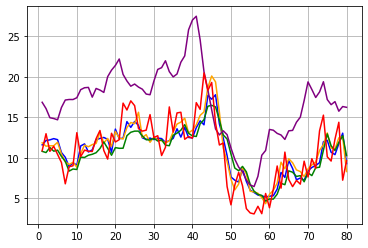

In [181]:
plt.plot(np.arange(1,len(y_true25)+1), xgb_pred25, label='xgb', color='blue')
plt.plot(np.arange(1,len(y_true25)+1), ridge_pred25, label='ridge', color='orange')
plt.plot(np.arange(1,len(y_true25)+1), ts_pred25, label='tslearn', color='green')
plt.plot(np.arange(1,len(lstm_25)+1), lstm_25, label='lstm', color='purple')

plt.plot(np.arange(1,len(y_true25)+1), y_true25, color='red')
plt.grid()
plt.savefig('overview2.png', dpi=150)
plt.show()

In [178]:
mean_absolute_error(results25['y_true'], results25['y_pred'])

6.659907312751863

In [99]:
mean_absolute_error(y_true25, ts_pred25)

2.2481483097839123